In [1]:
from skimage.io import imshow # For testing
from functools import partial
from time import perf_counter
import pandas as pd
import numpy as np
import random
import h5py
import os

import matplotlib.pyplot as plt
import seaborn

In [32]:
# Define path names here
image_path_prefix = 'data/Category and Attribute Prediction Benchmark/Img/Img/'
proc_img_path_prefix = 'data/Category and Attribute Prediction Benchmark/Img/Img/proc_'
image_to_category = 'data/Category and Attribute Prediction Benchmark/Anno/list_category_img.txt'
img_net_class_path = 'data/ImageNetClasses/imagenet1000_clsid_to_human.txt'
deep_fash_class_path = 'data/Category and Attribute Prediction Benchmark/Anno/list_category_cloth.txt'
proc_img_path = 'intermediates/processed_images.hdf5'

n_images_loaded = -1 # -1 loads all

# Data Preprocessing

In [120]:
from skimage.io import imread # uses PIL on the backend

def load_data(identifier,chunksize):
    labels = determine_data_subset(identifier)
    for image_info in read_data(labels,chunksize):
        yield (len(labels) + chunksize - 1)//chunksize, image_info
        
def determine_data_subset(identifier):
    n_top_labels = 10
    
    # Read in the attribute information to figure out what images to load
    cat_labels = pd.read_csv(identifier,skiprows=1,sep='\s+')
    
    # Figure out which are the most frequent labels to keep
    cat_label_count = cat_labels.groupby('category_label').count()
    cat_label_count = cat_label_count.sort_values(by=['image_name'],ascending=False)
    kept_labels = cat_label_count.head(n_top_labels).index
    
    # Filter labels not in the n_top_labels most frequent
    cat_labels = cat_labels.loc[cat_labels['category_label'].isin(kept_labels)]
    
    if n_images_loaded != -1:
        return cat_labels.head(n_images_loaded)
    else:
        return cat_labels

def read_data(labels,chunksize):
    def load_image_data(image_path):
        """Given an image path, load the data as an array"""
        image = imread(image_path_prefix+image_path,plugin='pil')
        return image
    
    # Store arrays containing the image data for all images
    for chunk in range(0,len(labels),chunksize):
        label_subset = labels.iloc[chunk:chunk+chunksize,:]
        label_subset['image'] = label_subset['image_name'].apply(load_image_data)
        yield label_subset   

In [43]:
from skimage.transform import rescale

def preprocess_data(data):
    data['image'] = scale_images(data['image'])
    data['image'] = fill_image(data['image'])
    return data

def scale_images(image_series):
    """
    Scale images so first dimension is 224 for input to ImageNet
    """
    def first_dim_224(img):
        """Scale first dimension of image to 224 pixels"""
        height = img.shape[0]
        return rescale(img,224/height,mode='constant')
    rescaled = image_series.apply(first_dim_224)
    return rescaled

def fill_image(image_series):
    """
    Pad second dimension of images with black or crop until length 224 reached
    """
    def pad_with_black(img):
        """
        If image's x dim is less than 224 pixels pad with black. If too large crop to 224.
        Modification spread evenly across both sides.
        """
        pix_to_pad = 224 - img.shape[1]
        if pix_to_pad < 0:
            # Crop the image
            pix_to_crop = -pix_to_pad
            img = img[:,pix_to_crop//2:-((pix_to_crop+1)//2),:]
        else:
            # Pad the image
            img = np.pad(img,[(0,0),((pix_to_pad+1)//2,pix_to_pad//2),(0,0)],mode='constant')
        return img
    padded = image_series.apply(pad_with_black)
    return padded

In [22]:
from skimage.io import imsave

def save_proc_images(img_df):
    """Saves processed images to disk. Assumes directory structure already in place"""
    def save_image(row):
        imsave(proc_img_path_prefix+row['image_name'],row['image'],plugin='pil')
    img_df.apply(save_image,axis=1)

In [ ]:
## Save processed images to disk as jpeg
chunksize = 5000

start = perf_counter(); image_count = 0
i_chunk = 0
for n_chunk, img_df in load_data(image_to_category,chunksize):
    img_df = preprocess_data(img_df)
    save_proc_images(img_df)
    
    image_count += len(img_df)
    i_chunk += 1    
    print('Chunk {} of {} complete'.format(i_chunk,n_chunk))
print('Took {} seconds to preprocess {} images'.format(perf_counter() - start,image_count))

/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
# Handle storing data to HDF5 here. Need special treatment due to numpy arrays
def store_to_hdf5(hdfstore,img_df,i_chunk):
    img_df[['image_name','category_label']].to_hdf(hdfstore,'chunk{}/info'.format(i_chunk))
    
    hdfstore.put('chunk{}/image'.format(i_chunk),pd.DataFrame(
        img_df['image'].apply(lambda x: np.ravel(x)).values
    ))

In [10]:
# Load and preprocess the image data
# Broke at chunksize 500 at chunk 197
chunksize = 1500 # Field becomes too large to store if this goes much higher

# Clear the stored file if it already exists
if os.path.exists(proc_img_path):
    os.remove(proc_img_path)

start = perf_counter(); image_count = 0
with pd.HDFStore(proc_img_path,'a',complevel=9) as proc_img_hdf:
    i_chunk = 0
    for n_chunk, img_df in load_data(image_to_category,chunksize):
        img_df = preprocess_data(img_df)
        store_to_hdf5(proc_img_hdf,img_df,i_chunk)
#        img_df.to_hdf(proc_img_hdf,'image/chunk{}'.format(i_chunk))

        image_count += len(img_df)
        i_chunk += 1
        print('Chunk {} of {} complete'.format(i_chunk,n_chunk))
    proc_img_hdf.get_node('image')._f_setattr('chunksize',chunksize)
print('Took {} seconds to preprocess {} images'.format(perf_counter() - start,image_count))

/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://p

Chunk 1 of 193 complete
Chunk 2 of 193 complete
Chunk 3 of 193 complete
Chunk 4 of 193 complete
Chunk 5 of 193 complete
Chunk 6 of 193 complete
Chunk 7 of 193 complete
Chunk 8 of 193 complete
Chunk 9 of 193 complete
Chunk 10 of 193 complete
Chunk 11 of 193 complete
Chunk 12 of 193 complete
Chunk 13 of 193 complete
Chunk 14 of 193 complete
Chunk 15 of 193 complete
Chunk 16 of 193 complete
Chunk 17 of 193 complete
Chunk 18 of 193 complete
Chunk 19 of 193 complete
Chunk 20 of 193 complete
Chunk 21 of 193 complete
Chunk 22 of 193 complete
Chunk 23 of 193 complete
Chunk 24 of 193 complete
Chunk 25 of 193 complete
Chunk 26 of 193 complete
Chunk 27 of 193 complete
Chunk 28 of 193 complete
Chunk 29 of 193 complete
Chunk 30 of 193 complete
Chunk 31 of 193 complete
Chunk 32 of 193 complete
Chunk 33 of 193 complete
Chunk 34 of 193 complete


KeyboardInterrupt: 

# Descriptive Info

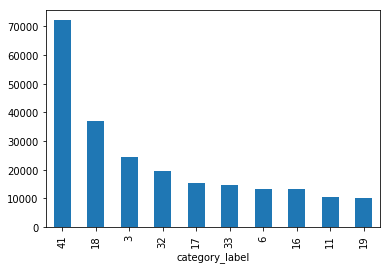

In [122]:
# Categories by number of occurences in img_df
labels = determine_data_subset(image_to_category)
labels.groupby('category_label')['image_name'].count().sort_values(ascending=False).plot(kind='bar')
plt.show()

In [ ]:
# Shows images from the last images to be processed
imshow(img_df['image'].iloc[random.randint(0,img_df.shape[0]-1)])
plt.show()

# Baseline Statistics

In [ ]:
# Declare the ImageNet models we'll use as  a baseline
from keras.applications.resnet50 import ResNet50
#from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception

# define ResNet50 model
res50 = ResNet50(weights='imagenet')
#vgg19 = VGG19(weights='imagenet')
incv3 = InceptionV3(weights='imagenet')
xcept = Xception(weights='imagenet')

The DeepFashion dataset assigns one clothing category to each image, even if more articles of clothing are visible. To account for this, when predicting we take the most likely category as the sole image category. 

When comparing ImageNet predictions to DeepFashion predictions, category names are matched by hand. However, not all categories have a reasonable counterpart. For this reason we calculate accuracy considering only those categories that can be matched. More explicitly: 
- We exclude all images from the DeepFashion dataset that do not have at least one ImageNet category corresponding to their true category
- When calculating the most probable ImageNet category, we only take the max probability across ImageNet categories that can be matched to a DeepFashion category
- A prediction is always made - no matter how low the category probability 

In [ ]:
## Generate some statistics on how ImageNet models with no tuning perform on the DeepFashion dataset
model_dict = {
        'resnet' : res50,
#        'vgg19' : vgg19,
        'inception_v3' : incv3,
        'xception' : xcept,
    }

def generate_baseline_stats(img_df):
    """
    Generates a report on the baseline performance of a pre-trained ImageNet classifier
    """
    # Map of the ImageNet labels to DeepFashion labels
    # Determined by crossreferencing:
    #     https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
    # with the DeepFashion category labels which match the (1 based) index as listed in: 
    #      data/Category and Attribute Prediction Benchmark/Anno/list_category_cloth
    # Top 10 IDs: 41, 18, 3, 32, 17, 33, 6, 16, 11, 19
    # The associations are not perfect, they will be evaluated individually later
    img_net_to_deep_fash_names = {
        'overskirt' : ['Dress'], # ?
        'hoopskirt, crinoline' : ['Dress'], # ?
        'jersey, T-shirt, tee shirt' : ['Tee','Blouse'], # OK, ?
#        : 'Shorts',
#        : 'Tank',
        'miniskirt, mini' : ['Skirt'], # OK
#        : 'Cardigan',
        'sweatshirt' : ['Sweater'], # ?
#        : 'Jacket',
#        : 'Top', # Too diverse - may want to drop entirely
    }
    img_net_to_deep_fash_id = build_id_map(img_net_to_deep_fash_names)
    
    # Only predict on images with a category ImageNet models can predict
    valid_ids = [ id_ + 1 for id_list in img_net_to_deep_fash_id.values() for id_ in id_list ]
    relevant_img_df = img_df.loc[img_df['category_label'].isin(valid_ids),:]


    # Get the prediction accuracy with each of the models in model_dict below
    image_net_predict(img_net_to_deep_fash_id,model_dict,relevant_img_df)
    acc_dict = calc_accuracy(img_net_to_deep_fash_id,model_dict,relevant_img_df)
    return acc_dict
    
def image_net_predict(id_map,model_dict,img_df):
    """"""
    for name, model in model_dict.items():
        start = perf_counter()
        preds = model.predict(np.stack(img_df['image'].values))
        print('{} took {} seconds to predict {} images'.format(name,perf_counter() - start,len(preds)))
        img_df[name] = get_img_net_cat(preds,id_map)

def get_img_net_cat(preds,id_map):
    # Get just the predictions for categories that map to DeepFashion categories
    valid_cat_ids = list(id_map.keys())
    preds = preds[:,valid_cat_ids]
    
    # Get the most probable index as indexed in the full ImageNet category list
    max_indices = np.argmax(preds,axis=1)
    max_indices = [ valid_cat_ids[ind] for ind in max_indices ]
    return max_indices

def calc_accuracy(id_map,model_dict,img_df):
    def get_outcome(model_name,row):
        pred = id_map[row[model_name]]
        if row['category_label'] - 1 in pred:
            return 1
        return 0
    acc_dict = {}
    for name in model_dict.keys():
        acc_dict[name] = sum(img_df.apply(partial(get_outcome,name),axis=1))/img_df.shape[0]
    return acc_dict

def build_id_map(name_map):
    # Get ImageNet ID to name map. IDs start at 0
    with open(img_net_class_path) as class_def:
        img_net_dict = eval(''.join(list(class_def)))
    
    # Get DeepFashion ID to name map. IDs start at 0
    deep_fash_dict = pd.read_csv(deep_fash_class_path,
                    skiprows=1,sep='\s+',usecols=['category_name']).to_dict()['category_name']
    
    # Reverse the dictionaries
    img_net_dict = { val : key for key, val in img_net_dict.items() }
    deep_fash_dict = { val : key for key, val in deep_fash_dict.items() }

    net_id_to_fash_id = {}
    for k,v in name_map.items():
        for name in v:
            try:
                net_id_to_fash_id[img_net_dict[k]].append(deep_fash_dict[name])
            except (KeyError,AttributeError):
                net_id_to_fash_id[img_net_dict[k]] = [deep_fash_dict[name]]
    return net_id_to_fash_id

In [ ]:
generate_baseline_stats(img_df)

Given the results above, I think my chosen mapping may not be that accurate. The chosen models have well over 80% accuracy on the ImageNet dataset. Numbers as low as those reported above signals a problem with the data, likely the choice of corresponding classes is not the best. 

# Bottleneck Feature Calculation

In [ ]:
def first_frozen_layer(base_model,unfrozen_layers):
    """
    Returns the layer just before the first unfrozen layer, the output node index 
    and inbound node index for that layer. 
    Unfrozen layers only counts layers with trainable weights. 
    base_model - The model with layers we want to freeze
    unfrozen_layers - The number of trainable layers to skip before the target layer
    """
    unfrozen_count = 0 # -1 because we want one more than the unfrozen_layers
    # Get the name of the first layer to be left frozen
    for l_num in range(len(base_model.layers_by_depth)):
        if unfrozen_count == unfrozen_layers:
            break
        for layer in base_model.layers_by_depth[l_num]:
            if layer.weights:
                unfrozen_count += 1
                if unfrozen_count == unfrozen_layers:
                    target_index = get_target_index(l_num,base_model.layers_by_depth)
                    in_node, out_node = get_node_indices(target_index,base_model.layers_by_depth)
                    break
        
    try:
        return target_index, in_node, out_node
    except NameError:
        print('Error: All layers or more layers than the network has left unfrozen')
        raise(AssertionError)
        
def get_target_index(l_num,layer_dict):
    """Gets the layer index before the layer at l_num"""
    l_num += 1
    # Avoid multiple layer entries, complicates implementation
    while len(layer_dict[l_num]) != 1:
        l_num += 1
    return l_num
        
def get_node_indices(layer_key, layer_dict):
    """Making sure we get the right input and output nodes for the layer"""
    # Will complete implementation if necessary. Will be difficult to handle edge cases right
    return -1, 0

    target_layer = layer_dict[layer_key]
    if len(target_layer.outbound_nodes) == 1:
        out_ind = 0
    else:
        # Scan to end of network for first matching node
        out_ind = -1
        cur_ind = layer_key - 1
        while cur_ind >= 0:
            for layer in layer_dict[cur_ind]:
                for node in layer.inbound_nodes:
                    if node in target_layer.outbound_nodes:
                        out_ind = target_layer.outbound_nodes.index(node)
            if out_ind != -1:
                break
            cur_ind -= 1
    
    if len(target_layer.inbound_nodes) == 1:
        in_ind = 0
    else:
        # Scan to end of network for first matching node
        in_ind = -1
        cur_ind = layer_key + 1
        while cur_ind < len(layer_dict):
            for layer in layer_dict[cur_ind]:
                for node in layer.outbound_nodes:
                    if node in target_layer.inbound_nodes:
                        in_ind = target_layer.inbound_nodes.index(node)
            if in_ind != -1:
                return in_ind, out_ind
            cur_ind += 1
        in_ind = 0
    return in_ind, out_ind

In [ ]:
## Generate bottleneck features and store them
img_df = pd.read_hdf('intermediates/processed_images.hdf5','images')

with pd.HDFStore('intermediates/bottleneck_feats.hdf5','w') as feat_store:
    feat_store.append('labels',img_df[['image_name','category_label']])
    for name, model in model_dict.items():
        # A max of 5 trainable layers back from output will be trained
        out_index, in_node, out_node = first_frozen_layer(model,5)
        bottleneck_model = Model(inputs=model.input,outputs=model.layers_by_depth[out_index][0].get_output_at(out_node))
        
        # Break into batches over images here if necessary
        start = perf_counter()
        bottleneck_feats = bottleneck_model.predict(np.stack(img_df['image'].values))
        print('{} took {} seconds to generate {} feature sets'.format(name,perf_counter() - start,len(bottleneck_feats)))
        # all are 4D arrays, will need to find a more robust storage method if that changes
        feat_store.append('feat_data/'+name,pd.Panel4D(bottleneck_feats))

# Hyperparameter Optimization

Now a model tuned to the DeepFashion dataset will be trained. The considered hyperparameters will
be:
- Transfer learning base: Resnet, Inception V3, Xception
- Layer at which to unfreeze weights
- Epoch to stop training

In [ ]:
def clone_model_until_layer(base_model,first_layer,]):
    """
    Copies base_model's architecture from output to the given index.
    
    Adds a new custom output"""
model = Sequential()
model.add(InputLayer((7, 7, 512)))
layer1 = res50.layers_by_depth[6][0]
model.add(layer1)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
froze_layer = first_frozen_layer(res50,2)
model = Model(inputs=res50.input, outputs=froze_layer.get_output_at())

In [ ]:
res50.summary()

In [ ]:
model = Sequential()
model.add(InputLayer((1,23,4)))

In [ ]:
model.layers_by_depth

In [ ]:
res50.layers_by_depth

In [ ]:
res50.get_layer('bn3b_branch2c').inbound_nodes

In [ ]:
layer1.get_output_at(0)

In [ ]:
model.get_layer('input_13').output_shape

In [ ]:
model.summary()

In [ ]:
layer1.output_shape

In [ ]:
layer1.inbound_nodes.index(layer1.inbound_nodes[1])

In [ ]:
out = model.predict(np.random.random((3, 7, 7, 512)))

In [ ]:
'input',
 'input_layers',
 'input_layers_node_indices',
 'input_layers_tensor_indices',
 'input_mask',
 'input_names',
 'input_shape',
 'input_spec',
 'inputs',

In [ ]:
layer1.get

In [ ]:
## Search over hyperparameters for the best model
from sklearn.model_selection import StratifiedShuffleSplit
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Model, Sequential
from keras.layers import InputLayer
np.random.seed(313) # For reproducibility

def stratified_train_val_test(X,y):
    """Generate stratified train-val-test splits. Hard coded for 70-20-10 proportion"""
    # Train-test split
    sss = StratifiedShuffleSplit(n_splits=1,test_size=.1)
    train, test = next(sss.split(X,y))
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    
    # Train-validate split
    sss = StratifiedShuffleSplit(n_splits=1,test_size=2/9)
    train, valid = next(sss.split(X_train,y_train))
    X_valid, y_valid = X_train[valid], y_train[valid]
    X_train, y_train = X_train[train], y_train[train]
    return X_train, y_train, X_valid, y_valid, X_test, y_test

def generate_bottleneck_features(base_model,max_unfrozen_layers,input_data):
    output_layer, in_node_ind, out_node_ind = first_frozen_layer(base_model,max_unfrozen_layers)
    model = Model(inputs=base_model.input, outputs=output_layer.get_output_at(out_node_ind))
    model.compile()
    model.predict(input_data)

In [ ]:
from keras.models import clone_model

clone_model()

In [ ]:
def build_model(base_net,unfrozen_layers):
    """
    base_net - pretrained ImageNet classifier
    unfrozen_layers - number of layers to leave trainable in base_net
    """
    base_model = base_net(weights='imagenet')
    
    model = Model(inputs=base_model.input, outputs=base_model.get_layer(first_frozen).output)
            
    model
            
def create_pretrained_embedding_model(top_words,max_review_length,embedding_matrix):
    embedding_vector_length = 300
    model = Sequential()
    embedding_layer = Embedding(top_words,
                             embedding_vector_length,
                             weights=[embedding_matrix],
                             input_length=max_review_length,
                             trainable=False)
    model.add(embedding_layer)
    model.add(LSTM(100)) # LSTM layer, top_words x embedding_vector_length -> 100 dim 
    model.add(Dense(5, activation='softmax')) # The output node, 100 -> 5 dim
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model


    model = Model(inputs=base_model.input, outputs=base_model.get_layer(first_frozen).output)
    model

    return model
# checkpointer = ModelCheckpoint(filepath='saved_models/best_weights_{model}_{unfreeze}.hdf5', 
#                                verbose=1, save_best_only=True)
# 
# VGG16_model.fit(train_VGG16, train_targets, 
#           validation_data=(valid_VGG16, valid_targets),
#           epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/best_weights_{model}_{unfreeze}.hdf5', 
                                verbose=1, save_best_only=True)

model = KerasClassifier(build_fn=partial(build_model,base_net,unfrozen_layers),callbacks=[checkpointer],verbose=1)
# # grid search epochs, batch size and optimizer
# optimizers = ['rmsprop', 'adam']
# init = ['glorot_uniform', 'normal', 'uniform']
# epochs = [50, 100, 150]
# batches = [5, 10, 20]
# param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init)
# grid = GridSearchCV(estimator=model, param_grid=param_grid)
# grid_result = grid.fit(X, Y)